<a href="https://colab.research.google.com/github/Megapietia/Dark/blob/main/Portfolio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Imports**

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import pandas_datareader as reader
import datetime as dt
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **Experiments**

In [ ]:
df = pd.read_csv('4SBER.csv', usecols=['Дата','Цена', 'Изм. %'], engine='python')
# цена
cost = np.array(df['Цена'], dtype=str)
cost = np.char.replace(cost, ',', '.').astype(np.float32)
# доходность
change = np.array(df['Изм. %'], dtype='<U6')
change = np.char.replace(change, '%', '')
change = np.char.replace(change, ',', '.').astype(np.float32)
# дата
date = np.array(df['Дата'], dtype=str)
# итоговый датафрейм
findf = pd.DataFrame([date, cost, change])
findf = findf.transpose().rename(columns={0: 'Date',1: 'Cost', 2: 'Change'}).iloc[::-1]
findf
# Статистика
stats = pd.DataFrame([cost, change])
stats = stats.transpose().rename(columns={0: 'Cost', 1: 'Change'})
stats
# График
# findf.plot('Date', 'Cost')



FileNotFoundError: ignored

In [ ]:
SberStdCost = stats.std()[0]
SberStdChange = stats.std()[1]
SberMeanCost = stats.mean()[0]
SberMeanChange = stats.mean()[1]

NameError: ignored

In [ ]:
SberStdCost

In [ ]:
SberMeanCost

In [ ]:
stats.describe()

In [ ]:
def VaRWiki(Position, mu, sigma, Quantile, Period):
  return Position*(-mu*Period+scipy.stats.norm.ppf(Quantile)*sigma*(Period)**(1/2))
  

In [ ]:
VaRWiki(stats['Cost'].iloc[-1], SberMeanChange,SberStdChange, 0.95, 7/365)

# **Calculation VaR for portfolio**

In [ ]:
def VaR(Position,sigma,Quantile):
  return Position*sigma*scipy.stats.norm.ppf(Quantile)

In [ ]:
end = dt.datetime.now()
start = dt.datetime(end.year-4, end.month, end.day)

In [ ]:
period = ((end - start).days)/365
Quantile = 0.95

In [ ]:
df = reader.get_data_yahoo(['AAPL','MSFT','TSLA'], start, end)['Adj Close']

In [ ]:
returns = np.log(1+df.pct_change())

In [ ]:
returns.std()

Symbols
AAPL    0.020282
MSFT    0.018407
TSLA    0.039375
dtype: float64

In [ ]:
Position = df.iloc[-1]

In [ ]:
VaRarray = []
for i in range(len(Position)):
  VaRarray.append(VaR(Position[i], returns.std()[i], Quantile))

In [ ]:
VaRarray

[4.214670089324679, 7.1334632113992695, 45.35594595264133]

In [ ]:
vector = np.array(VaRarray)

In [ ]:
returns.corr()

Symbols,AAPL,MSFT,TSLA
Symbols,,,
AAPL,1.000000,0.752040,0.422317
MSFT,0.752040,1.000000,0.438527
TSLA,0.422317,0.438527,1.000000


In [ ]:
print(f"С вероятностью {Quantile} величина убытков портфеля не превысит {(np.dot(np.dot(vector, returns.corr()),vector))**(1/2)} долларов в течение {period} лет")

С вероятностью 0.95 величина убытков портфеля не превысит 51.14938274882958 долларов в течение 4.002739726027397 лет


# **Calculating beta,alpha and creating regression model(Sharp model)**

In [ ]:
end = dt.datetime.now()
start = dt.date(end.year - 1, end.month,end.day)
Input = ['TSLA', '^GSPC']

In [ ]:
df = reader.get_data_yahoo(Input, start, end)['Adj Close']
df.head()

Symbols,TSLA,^GSPC
Date,,
2020-03-05,144.908005,3023.939941
2020-03-06,140.695999,2972.370117
2020-03-09,121.599998,2746.560059
2020-03-10,129.065994,2882.229980
2020-03-11,126.846001,2741.379883


In [ ]:
dl_ret = df.resample('M').ffill().pct_change()
dl_ret = dl_ret.dropna(axis=0)
dl_ret.head()

Symbols,TSLA,^GSPC
Date,,
2020-04-30,0.492137,0.126844
2020-05-31,0.067939,0.045282
2020-06-30,0.293186,0.018388
2020-07-31,0.325011,0.055101
2020-08-31,0.741452,0.070065


In [ ]:
X =  dl_ret['^GSPC']
y = dl_ret['TSLA']
X_sm = sm.add_constant(X)

In [ ]:
model = sm.OLS(y, X_sm)
results = model.fit()

In [ ]:
results.summary()

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   TSLA   R-squared:                       0.621
Model:                            OLS   Adj. R-squared:                  0.583
Method:                 Least Squares   F-statistic:                     16.36
Date:                Fri, 05 Mar 2021   Prob (F-statistic):            0.00234
Time:                        15:46:06   Log-Likelihood:                 4.0674
No. Observations:                  12   AIC:                            -4.135
Df Residuals:                      10   BIC:                            -3.165
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0394      0.065      0.604      0.559      -0.106       0.185
^GSPC          4.4281      1.095      4.045      0.002       1.989       6.867
==============================================================================
Omnibus:                        1.986   Durbin-Watson:                   1.858
Prob(Omnibus):                  0.370   Jarque-Bera (JB):                0.552
Skew:                           0.509   Prob(JB):                        0.759
Kurtosis:                       3.258   Cond. No.                         20.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
alpha = results.params[0]
beta = results.params[1]
print(f'alpha: {alpha}, beta: {beta}')

alpha: 0.03944949794813607, beta: 4.428057867038923


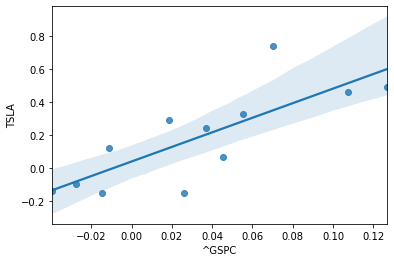

In [ ]:
sns.regplot(x='^GSPC', y='TSLA', data=dl_ret)
plt.show()

# **Stock price simulation**

In [ ]:
days_ToPred = 252

In [ ]:
end = dt.datetime.now()
start = dt.datetime(end.year-5, end.month, end.day)

In [ ]:
df = reader.get_data_yahoo(['AAPL'], start, end)['Adj Close']
df.describe()

Symbols,AAPL
count,1259.000000
mean,54.298968
std,29.736891
min,21.134403
25%,34.987810
50%,44.532402
75%,64.370293
max,142.946396


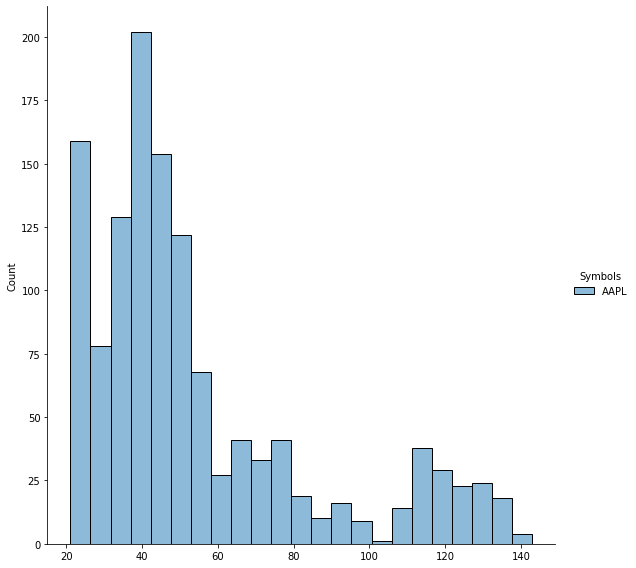

In [ ]:
sns.displot(df, height=8)

In [ ]:
returns = np.log(1+df.pct_change())
mu, sigma = returns.mean(), returns.std()


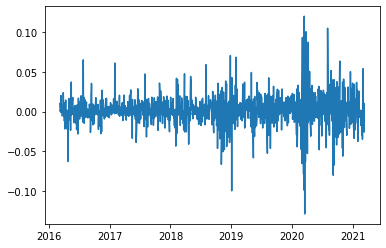

In [ ]:
plt.plot(returns)
plt.show()

In [ ]:
sim_rets = np.random.normal(mu,sigma,days_ToPred)
initial = df.iloc[-1][0]

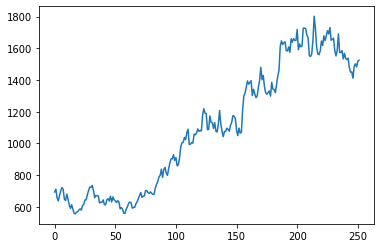

In [ ]:
sim_prices = initial * (sim_rets + 1).cumprod()
plt.plot(sim_prices)

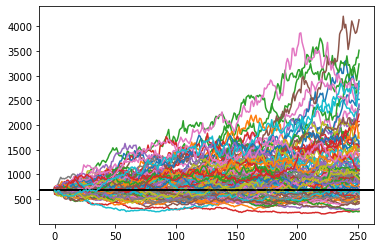

In [ ]:
for i in range(100):
  sim_rets = np.random.normal(mu,sigma,days_ToPred)
  sim_prices = initial * (sim_rets + 1).cumprod()
  plt.axhline(initial,c='k')
  plt.plot(sim_prices)

Text(0.5, 6.79999999999999, 'Price after 252 days')

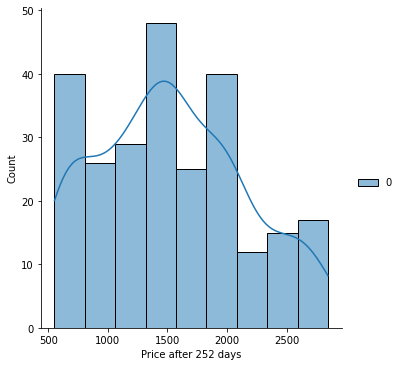

In [ ]:
sns.displot(pd.DataFrame(sim_prices), kde=True)
plt.xlabel(f"Price after {days_ToPred} days")


In [ ]:
pd.DataFrame(sim_prices).describe()

,0
count,252.000000
mean,1525.960082
std,615.091235
min,552.428016
25%,1029.238961
50%,1492.330794
75%,1969.137878
max,2845.729755


# **Stock price simulation 2**

In [238]:
end = dt.datetime.now()
start = dt.datetime(end.year-5, end.month, end.day)

In [239]:
ticks = ['JNJ']
data = pd.DataFrame(reader.get_data_yahoo(ticks, start, end)['Adj Close'])
new_data = pd.DataFrame(reader.get_data_yahoo(ticks, start, end)['Adj Close'])

In [240]:
last_price = round(new_data.iloc[-1].values[0], 2)

In [241]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [242]:
log_return = log_returns(data).dropna()

In [243]:
def simple_returns(data):
    return ((data/data.shift(1))-1).dropna()

In [244]:
def market_data_combination(data, mark_ticker = "^GSPC"):
    market_data = pd.DataFrame(pd.DataFrame(reader.get_data_yahoo("^GSPC", start, end)['Adj Close']).rename(columns={'Adj Close': '^GSPC'}))
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values-1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [245]:
def beta_sharpe(data, mark_ticker="^GSPC", riskfree = 0.025):
    dd, mark_ret = market_data_combination(data)
    log_ret = log_returns(dd)
    covar = log_ret.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    mrk_var = log_ret.iloc[:,-1].var()*252
    beta = covar/mrk_var
    
    stdev_ret = pd.DataFrame(((log_ret.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_ret, left_index=True, right_index=True)
    
    # CAPM
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_ret-riskfree))
    # Sharpe
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM']-riskfree)/(row['STD']))
    beta.rename(columns={"^GSPC":"Beta"}, inplace=True)
    
    return beta

In [246]:
beta_sharpe(data)

,Beta,STD,CAPM,Sharpe
JNJ,0.653957,0.198314,0.102705,0.391827


In [247]:
def drift_calc(data, return_type='log'):
    if return_type=='log':
        lr = log_returns(data)
    elif return_type=='simple':
        lr = simple_returns(data)
    mu = lr.mean()
    var = lr.var()
    drift = mu-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [248]:
drift_calc(data)

array([0.00034439])

In [249]:
def daily_returns(data, days, iterations, return_type='log'):
    ft = drift_calc(data, return_type)
    if return_type == 'log':
        try:
            stv = log_returns(data).std().values
        except:
            stv = log_returns(data).std()
    elif return_type=='simple':
        try:
            stv = simple_returns(data).std().values
        except:
            stv = simple_returns(data).std()    
    dr = np.exp(ft + stv * scipy.stats.norm.ppf(np.random.rand(days, iterations)))
    return dr


In [250]:
dr = daily_returns(data, 2, 3)
dr

array([[1.00626147, 1.01372663, 1.00621824],
       [0.98238595, 0.98700441, 1.00772137]])

In [251]:
def probs_find(predicted, higherthan, on = 'value'):
    if on == 'return':
        predicted0 = predicted.iloc[0,0]
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 >= higherthan]
        less = [(i*100)/predicted0 for i in predList if ((i-predicted0)*100)/predicted0 < higherthan]
    elif on == 'value':
        predicted = predicted.iloc[-1]
        predList = list(predicted)
        over = [i for i in predList if i >= higherthan]
        less = [i for i in predList if i < higherthan]
    else:
        print("'on' must be either value or return")
    return (len(over)/(len(over)+len(less)))

In [252]:
def simulate_mc(data, days, iterations, return_type='log', plot=True):
    # Generate daily returns
    returns = daily_returns(data, days, iterations, return_type)
    # Create empty matrix
    price_list = np.zeros_like(returns)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    returns_array = []
    price_array = []
    for t in range(1,days):
        price_list[t] = price_list[t-1]*returns[t]
        np.log(1+data.pct_change())
        # print(np.array(np.log(1+pd.DataFrame(price_list[t]).pct_change()).mean()))
        # print(np.array(np.log(1+(price_list[t]-price_list[t-1])/price_list[t]).mean()))
        returns_array.append(((price_list[t]-price_list[t-1])/price_list[t]).mean())

    
    # Plot Option
    if plot == True:
        x = pd.DataFrame(price_list).iloc[-1]
        sns.displot(x, kde=True, aspect=2)
        plt.xlabel("Stock Price")
        plt.show()
    
    # Printing information about stock
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days-1}")
    print(f"last price: ${last_price}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list).iloc[-1].mean(),5)}")
    print(f"Return: {((pd.DataFrame(price_list).iloc[-1].mean()-price_list[0,1])/pd.DataFrame(price_list).iloc[-1].mean())}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list),0, on='return')}")
    print(beta_sharpe(data).iloc[0].transpose().to_string())
    print(pd.DataFrame(price_list).iloc[-1].describe(percentiles=[.95, .99, .5, .6]))  
    return returns_array

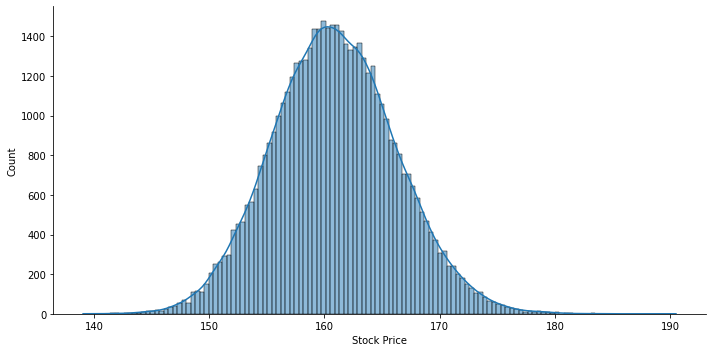

JNJ
Days: 7
last price: $160.41
Expected Value: $160.89277
Return: 0.003000532496651131%
Probability of Breakeven: 0.52794
Beta      0.653957
STD       0.198314
CAPM      0.102706
Sharpe    0.391831
count    50000.000000
mean       160.892768
std          5.356227
min        139.064803
50%        160.794570
60%        162.166647
95%        169.839206
99%        173.758599
max        190.509651
Name: 7, dtype: float64


[0.00024166944690603244,
 0.0002140792034199616,
 0.0003603844196840158,
 0.00028575244167518266,
 0.0002559438545619591,
 0.0002711206894925571,
 0.0002700932017188018]

In [253]:
simulate_mc(data, 8, 50000, 'log')

In [254]:
print((3.76-3.7)/3.76)

0.015957446808510536


In [255]:
# 09.03.2021 - start date for 14 days
HP = np.array([-0.0015918186366791235,
 -0.001542175884664001,
 -0.0012045795382608219,
 -0.0016956775850267127,
 -0.001799422467103809,
 -0.001386921438516002,
 -0.0015146376506500604,
 -0.0015360135806728396,
 -0.0015787160559057089,
 -0.0014349829332777552,
 -0.0015952490281427002,
 -0.0014355282832429037,
 -0.0014253590754024742,
 -0.0015705170132550748])
INTEL = np.array([3.2218458972584184e-05,
 0.00032490314525626326,
 0.0001699974065265205,
 0.00035777962741824704,
 5.913893456422587e-05,
 0.0002520177485536957,
 0.00026692117567712886,
 8.559087588157143e-05,
 0.00012013720416217853,
 9.468441563934764e-05,
 0.0002132729242048172,
 0.00022649016762661006,
 0.00017787499327431857,
 8.223778433830721e-05])
MSFT = np.array([0.000876012617843982,
 0.0008524414454125452,
 0.0008877153845684739,
 0.0009132390040515209,
 0.0008461543404539776,
 0.0008668736071337465,
 0.0008644886541462769,
 0.0009475335937235795,
 0.000837526944653227,
 0.0009501925560503137,
 0.0010750130008723012,
 0.0011088257749148945,
 0.0009199996124354492,
 0.001013462866825368])
MU= np.array([0.0008904315553588423,
 0.0008972804706349588,
 0.0006579192307353658,
 0.0007396368145122843,
 0.0005151670783409462,
 0.0008390825904853166,
 0.0008060547387297764,
 0.0006726226849097327,
 0.0008876565201652311,
 0.0007831717442038978,
 0.000769686629811869,
 0.0006675508443725151,
 0.0008024644247325548,
 0.0009070846113721745])
DIS = np.array([0.0002839311185956654,
 0.0002456147195954908,
 0.0003793268977972077,
 0.0003640901032881842,
 0.00023511272577349224,
 0.0002774582297296738,
 0.00032554029862582744,
 0.00034373735890376976,
 0.0003989964305653657,
 0.00045906291602963235,
 0.0002806717339210822,
 0.00033781527565265656,
 0.000392718068127378,
 0.00024185894470583132])
BKNG = np.array([9.078398902819402e-05,
 0.00012501386395081417,
 -4.840065967506245e-05,
 0.0002295273843499752,
 -0.00020539487786829115,
 0.00014202582903033307,
 -2.675616586776901e-05,
 0.0001876267030764253,
 -0.00019411887814806125,
 0.00018572465557326794,
 -6.803012069080204e-05,
 4.7986172157075905e-05,
 7.68346460754317e-05,
 7.985251321637866e-05])
EZJL = np.array([-0.0012752338454331109,
 -0.0013142056212457611,
 -0.0012672999100318896,
 -0.001271259092824653,
 -0.0011829181689499795,
 -0.0012947124647216953,
 -0.0015171532805706585,
 -0.0015121632016843018,
 -0.0011773225144154163,
 -0.0010552151321184763,
 -0.0013621512785932759,
 -0.0013842479015410767,
 -0.0013218992699748629,
 -0.0011894558888531231])
ATVI = np.array([0.000446017762035828,
 0.00027043882525717175,
 0.00025113074852954777,
 0.0003624867578507296,
 0.0004384677239879856,
 0.00044313690707672065,
 0.00018104179387413616,
 0.00042581815660377087,
 0.0004777441598373131,
 0.0005733892528817207,
 0.00036413999032116386,
 0.0004601379073443691,
 0.00043626303341865835,
 0.00027992230325902374])
NFLX = np.array([0.0006212447481416272,
 0.0006926743880902744,
 0.0006564008381180775,
 0.0005057560297975465,
 0.0006085094292111499,
 0.0007990128276194018,
 0.00044522723621083195,
 0.0008066577829628644,
 0.0006881989629537331,
 0.0005726132377490134,
 0.0002750417177511001,
 0.0006227578378720859,
 0.0006376686695549852,
 0.000584425833396686])
SBUX = np.array([0.0002030403673100146,
 0.00043319000970893517,
 0.00020822158200401358,
 0.0004319753549233572,
 0.0002767673549106265,
 0.0002916785832441253,
 0.000316722793526399,
 0.0004247281818707711,
 0.00026398177997208057,
 9.679655193596233e-05,
 0.00015571477026953524,
 0.00019762503156366273,
 0.00019568586650731202,
 0.0002612497972021408])
DPZ = np.array([0.0003834477543521899,
 0.0003365110103109941,
 0.0003918187084059291,
 0.0003381007302366189,
 0.0005432427394323438,
 0.00021973386593701928,
 0.00047278808050986844,
 0.0005128509305548856,
 0.000313332781187571,
 0.00039252197493247655,
 0.0003459486206370826,
 0.0004222662775827402,
 0.0005669937004788104,
 0.0004435032340679585])
BKR = np.array([-0.000902390016907206,
 -0.0006388239123175722,
 -0.0006999449762915662,
 -0.0010264215344680523,
 -0.0007491226906002172,
 -0.0007732171700086876,
 -0.0007688865226790368,
 -0.0008441947987995256,
 -0.0006524851903750597,
 -0.0008895283402547054,
 -0.0008231488715794459,
 -0.0006048914123958035,
 -0.0007459855099915284,
 -0.0008512633652330701])
CVX = np.array([1.653744034630043e-05,
 -0.00012363390066613312,
 -0.00013453449102838677,
 -0.00011500074033962889,
 -0.00013846093004830378,
 -0.00017868779113642218,
 -2.9571999685182493e-05,
 0.0001822583758561718,
 -0.00011886091949833321,
 -9.668125627220618e-05,
 -0.0002451790524323286,
 8.692050264165012e-06,
 -7.904061092303879e-05,
 -0.00018196793911004835])
NKE = np.array([0.00031897678531800144,
 0.0004444921790724262,
 0.0005352374360457456,
 0.0006165158146924452,
 0.00024608039599797034,
 0.00039656027759710276,
 0.00043362148587023014,
 0.0005607567248810326,
 0.0003356440830219561,
 0.00046199509517374105,
 0.0003619689331912073,
 0.0005664382525802425,
 0.000345575109155605,
 0.00037303569707993845])
MRNA = np.array([0.0008847788814444732,
 0.0007763961987234238,
 0.0006444773925239315,
 0.0007298057317203601,
 0.0001341701755079312,
 0.0006002634483594665,
 0.0010634248422704818,
 0.0005201881263951102,
 0.000987125026588344,
 0.0005439933761974012,
 0.0007900985145098707,
 0.000699301839188171,
 9.033441750079309e-05,
 0.00041558154455604695])

# **DAILY RETURNS(1 week)**

In [600]:
MRNA = np.array([0.000820240469511062,
 0.0008941816927839288,
 0.0008183696340969068,
 0.0010473697891217463,
 0.0009132578796100074,
 0.0006573270985408959,
 0.0006236253924135407,
 0.00062241432])
NKE = np.array([0.0004940891207011449,
 0.0004157819208881886,
 0.00039774171909256155,
 0.00028648527968452403,
 0.0003238775542226169,
 0.0004592177591324314,
 0.000449162555002789,
 0.000444234214])
CVX = np.array([-0.00024978681341981853,
 -0.000208737686695237,
 -0.00011371910861461089,
 -5.305503966406831e-05,
 -0.00016191099162549428,
 -5.3056760964122845e-05,
 -0.00027580657395895536,
 -0.00027235235536])
BKR = np.array([-0.0009391150728270947,
 -0.0008015511774430908,
 -0.0006238367527182256,
 -0.0007832761084365451,
 -0.0008625020967926156,
 -0.0006837786639945683,
 -0.0008671614607888264,
-0.00086716123424388264])
DPZ = np.array([0.00045346246043134015,
 0.0003811903071624685,
 0.00037422273655259887,
 0.0004584552248762259,
 0.00042010282888828087,
 0.0004860690215285052,
 0.0006369597821544149,
 0.00063695335353149])
SBUX = np.array([0.0002400834995413794,
 0.0003542966775821237,
 0.0003084011949507116,
 0.000290067768256251,
 0.0002890296617170806,
 0.00015822364876779218,
 0.00032455699687926445,
  0.0003245353242345])
NFLX = np.array([0.0005055660248378591,
 0.0006636188395165999,
 0.0005678385397921967,
 0.0007616563707752786,
 0.0005684444907616339,
 0.0007555097798542386,
 0.0007089860167032532,
  0.00070898635242532])
ATVI = np.array([0.000367129926648059,
 0.0003798552363569873,
 0.00048199139455722465,
 0.0004236635048545095,
 0.00040951542151836356,
 0.00040687248555718204,
 0.00025369800372359794,
 0.0002533535144])
EZJL = np.array([-0.0013623641189683675,
 -0.0013988393096812123,
 -0.0011315272978327533,
 -0.001368809544494363,
 -0.0012087570538726676,
 -0.0012024473388855957,
 -0.0013381845648130115,
 -0.001338135352420115])
BKNG = np.array([9.934005506664049e-05,
 4.450987643962884e-05,
 5.811319437454776e-05,
 0.00015813850369012964,
 3.7017779941351516e-06,
 5.037270833860962e-05,
 -1.7731144480741346e-05,
  -1.771313241346e-05])
DIS = np.array([0.0002661070019970931,
 0.00024011803356561106,
 0.0003076997100543523,
 0.00015462763793767904,
 0.00035846531535664106,
 0.00028486948743805806,
 0.00032220590974338305,
  0.0003222242452830])
MU = np.array([0.0007029537938540622,
 0.0010775314164776517,
 0.0006880958819134797,
 0.0007839256348996147,
 0.0008101236393582734,
 0.0008495438498101086,
 0.0008801604019946373,
 0.0008802425266373])
MSFT = np.array([0.0008029663590404657,
 0.0010088608869694299,
 0.0010179147966026228,
 0.0009722371302467224,
 0.0009388497552475579,
 0.0009356641536810146,
 0.0008429785079554609,
  0.0008436536659554609])
INTEL = np.array([0.00020626572474701928,
 -0.00013877976662818675,
 0.0002845482483448752,
 9.36765401848427e-05,
 0.0002178290801214372,
 0.000251331769830429,
 0.0001622401443756094,
 0.0001622425556094])
HP = np.array([-0.001533715666187592,
 -0.001513338141319869,
 -0.0016745687287203696,
 -0.0013452694540003424,
 -0.0016197916070169805,
 -0.001474848200548015,
 -0.0013192332160390026,
  -0.00125253160390026])

# **Tobin's portfolio**

In [213]:
# tickers = ['MRNA', 'NKE', 'CVX','BKR','DPZ','SBUX','NFLX','ATVI','EZJ.L','BKNG','DIS','MU','MSFT','INTC','HP']
# tickers = ['MRNA', 'NKE','DPZ','NFLX','EZJ.L','DIS','MU','MSFT']
tickers = ['MRNA','DPZ','NFLX','EZJ.L','MU','MSFT','EBAY','BABA','OGI']
end = dt.datetime.now()
start = dt.datetime(end.year-3, end.month, end.day)
data = pd.DataFrame(reader.get_data_yahoo(tickers, start, end)['Adj Close'])

In [214]:
returns = data.pct_change()

In [684]:
returns = pd.DataFrame(([MRNA,NKE,CVX,BKR,DPZ,SBUX,NFLX,ATVI,EZJL,BKNG,DIS,MU,MSFT,INTEL,HP]))
returns = returns.transpose().rename({0:'MRNA',1:'NKE',2:'CVX',3:'BKR',4:'DPZ',5:'SBUX', 6:'NFLX',7:'ATVI',8:'EZJL',9:'BKNG',10:'DIS', 11:'MU', 12:'MSFT',13:'INTEL', 14:'HP'},axis=1)

In [215]:
returns = returns.dropna()
returns

Symbols,MRNA,DPZ,NFLX,EZJ.L,MU,MSFT,EBAY,BABA,OGI
Date,,,,,,,,,
2019-05-22,-0.030837,-0.001895,0.015412,-0.058298,-0.025533,0.006068,-0.007381,-0.028147,-0.025608
2019-05-23,-0.028182,0.003094,-0.020905,-0.000216,-0.026202,-0.011671,-0.009915,-0.017818,-0.051248
2019-05-24,0.021048,-0.009463,0.006190,-0.008630,0.005322,0.000475,0.005007,-0.006410,0.037396
2019-05-28,-0.013284,-0.006652,0.001891,-0.010446,-0.031177,-0.000634,0.002491,-0.001226,0.048064
2019-05-29,0.007428,-0.010687,-0.016532,-0.023532,0.010625,-0.009670,-0.003313,-0.015051,-0.020382
...,...,...,...,...,...,...,...,...,...
2021-03-05,-0.000831,-0.000877,0.009975,-0.048464,0.054548,0.021479,0.007874,0.014707,-0.049645
2021-03-08,-0.065966,0.009902,-0.044656,0.037610,-0.043630,-0.018178,-0.005022,-0.030784,0.055970
2021-03-09,0.059934,0.061677,0.026575,-0.008395,0.049971,0.028101,0.050103,0.050509,0.091873


In [233]:
expected_ret_p = 0.01
# expected_ret = [0.02405,0.0049,0.0ф018,0.00ф15,0.0057,0.00ф39,0.0089,0.005ф9,0.0016,0.00ф33,0.00409,0.0119,0.0085,0.00ф42,0.000ф22]
# expected_ret = [0.02405,0.0049,0.0057,0.0089,0.0016,0.00409,0.0119,0.0085]
expected_ret = [0.02405,0.0057,0.0089,0.0016,0.0119,0.0085,0.00537,0.00636,0.0101]
# 0.003286
# Матрица ковариаций и обратная ей
V = np.matrix(returns.cov())
V_inv = np.linalg.inv(V)
# безрисковая ставка
M_f = 0.00038
# sharpe = beta_sharpe(data).iloc[0][3]

In [234]:
# test = np.matrix('133.3 -33.3;-33.3 33.3')
vector = np.array(expected_ret)
# Единичная матрица
I = np.ones((len(vector),1))
second = np.reshape(vector,(len(vector),1)) - M_f*I
first =  np.reshape((np.reshape(vector,(len(vector),1)) - M_f*I), (1,len(vector)))
G = np.dot(np.dot(first,V_inv),second)
# квадрат индекса Шарпа
g = round(np.array(G)[0][0],3)

In [235]:
g

0.379

In [236]:
# Оптимальные доли
V_opt = np.array(np.dot((((expected_ret_p-M_f)/g)*V_inv), second))
V_opt_f = 1 - sum(V_opt)
# for i in range(len(V_opt)):
#     print(V_opt[i])
for i in range(len(V_opt)):
    for j in range(len(V_opt[i])):
        print(f'{i+1}) доля актива {tickers[i]} составляет: ',V_opt[i][j], end=' ')
    print()

1) доля актива MRNA составляет:  0.2103964195161349 
2) доля актива DPZ составляет:  0.11123052164837288 
3) доля актива NFLX составляет:  0.14875865277740175 
4) доля актива EZJ.L составляет:  0.01292210426195461 
5) доля актива MU составляет:  0.1662751501671159 
6) доля актива MSFT составляет:  0.07746688422501183 
7) доля актива EBAY составляет:  0.0007741181026255936 
8) доля актива BABA составляет:  0.02479159803040943 
9) доля актива OGI составляет:  0.007368833938247429 


In [237]:
print(f'Доля безрискового актива составляет: {V_opt_f[0]}')

Доля безрискового актива составляет: 0.24001571733272575
